# Modelling

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import fiona
from datetime import datetime
import plotly.graph_objects as go
import shapely
import json
import networkx as nx
from linearmodels import PanelOLS
import matplotlib.pyplot as plt

# Seasonal Decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
mapbox_access_token = "pk.eyJ1IjoidGhhbXN1cHBwIiwiYSI6ImNrN3Z4eTk2cTA3M2czbG5udDBtM29ubGIifQ.3UvulsJUb0FSLnAOkJiRiA"

In [23]:
density = pd.read_csv('Population/pop_density.csv')
density = density.drop(['Code', 'Land Area'], axis = 1)
density = density.melt(id_vars = ['County', 'State'], var_name = 'Year', value_name = 'Density')
density['Year'] = density['Year'].astype(int)

In [24]:
huc_data = pd.read_csv('HUC_cumu_ps_data.csv')
hucs = huc_data['HUC12'].unique()

# Load the simplified GDF
keephuc = gpd.read_file('keephuc/keephuc.shp')
huc_areas = keephuc[['HUC12', 'AREASQKM']]
huc_areas['HUC12'] = huc_areas['HUC12'].apply(lambda x: np.int64(x))

C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
water = pd.read_csv('Water_FINAL.csv')
water = water.iloc[:,3:]
water = water.loc[water['HUC12_'].apply(lambda x: x in hucs), :]
water = water[['Parameter', 'MeasureValue', 'Point', 'Latitude', 'Longitude', 'HUC12_', 'HUCNAME_', 'COUNTY_', 'STATE_', 'Year',
       'Month', 'Day', 'Date', 'Time', 'coordinates', 'Station', 'StationCode']]
water.to_csv('water_condensed.csv', index = None)

KeyboardInterrupt: 

In [34]:
water = pd.read_csv('water_condensed.csv')

C:\Users\isaac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [38]:
params_to_keep = ['TN', 'TP', 'TSS', 'WTEMP', 'TURB_NTU', 'TDS', 'DO', 'NH4F', 'NO3F', 'PH', 'PO4F', 'SALINITY', 'SECCHI']
water = water.loc[water['Parameter'].apply(lambda x: x in params_to_keep), :]
water = water.reset_index(drop = True)
water = water.drop(['Station', 'StationCode'], axis = 1)

In [27]:
station_data = water[['Point', 'HUC12_', 'HUCNAME_', 'Latitude', 'Longitude', 'COUNTY_', 'STATE_']].drop_duplicates()

# Average the values from the same measure which are identical time and location
water = water.groupby(['Point', 'Year', 'Month', 'Parameter'])['MeasureValue'].mean().reset_index()

# Pivot such that the parameters are on the y-axis
water = water.pivot(index = ['Point', 'Year', 'Month'],
           columns = 'Parameter',
           values = 'MeasureValue').reset_index()

# Merge back the station data 
water = water.merge(station_data, how = 'left', on = 'Point')
water = water.rename(columns = {'HUC12_': 'HUC12', 'COUNTY_': 'County', 'STATE_': 'State'})

# Merge pop density data
water = water.merge(density[['County', 'State', 'Year', 'Density']], on = ['County', 'State', 'Year'], how = 'left')

In [28]:
# Set year and month for the HUC data
huc_load_data = huc_data.dropna(subset = ['Month'])
huc_load_data = huc_load_data.drop('num_ps', axis = 1)
huc_load_data['Year'] = huc_load_data['Month'].apply(lambda x: int(x[:4]))
huc_load_data['Month'] = huc_load_data['Month'].apply(lambda x: int(x[5:]))
huc_load_data = huc_load_data.reset_index(drop = True)
huc_ps_data = huc_data[['HUC12', 'num_ps']].drop_duplicates().dropna().reset_index(drop = True)

huc_data = huc_load_data.merge(huc_ps_data, on = 'HUC12')

huc_data = huc_data.merge(huc_areas, on = 'HUC12')

In [29]:
# Merge the HUC load data
water = water.merge(huc_data, on = ['HUC12', 'Month', 'Year'], how = 'left')

# Create load/area variable
water['tn_load_over_area'] = water['tn_load'] / water['AREASQKM']
water['tp_load_over_area'] = water['tp_load'] / water['AREASQKM']

In [31]:
water = water.drop(['ALKY.3', 'ALKY.6', 'AT.1', 'AT.10', 'AT.2',
       'AT.3', 'AT.5', 'AT.6', 'AT.9', 'CHL.1', 'CHL.2', 'CHL.3', 'CHL.4', 
        'CO.1', 'CO.2', 'CO.4', 'CO.5', 'CO.8', 'CO.9', 'DO.1', 'DO.15', 'DO.2', 'DO.3', 'DO.4',
       'DO.5', 'DO.6', 'DO.7', 'DO.8', 'DO.9','ECOLI.1', 'ECOLI.4', 'ECOLI.6',
       'ENT.2', 'NO3N.1', 'NO3N.5', 'NO3N.6', 'OP.1', 'OP.2',
       'OP.7', 'PH.1',
       'PH.11', 'PH.3', 'PH.4', 'PH.6', 'PH.9', 'SA.1', 'SA.10',
       'SA.3', 'SA.6', 'SA.8', 'SA.9', 'TD.1', 'TDS.1', 'TDS.2', 'TDS.3',  'TN.1', 'TN.2', 'TN.3',
        'TP.1', 'TP.2', 'TP.3', 'TSS.1', 'WC.1', 'WC.2', 'WC.4', 'WC.5', 'WC.6', 'WC.7', 'WC.9',
       'WT.1', 'WT.10', 'WT.13', 'WT.2', 'WT.3', 'WT.4', 'WT.5', 'WT.6',
       'WT.9'          ], axis = 1)

In [33]:
water.loc[(water['Latitude'] == )]

Index(['Point', 'Year', 'Month', 'CHLA', 'DO', 'NH4F', 'NO3F', 'PH', 'PO4F',
       'SALINITY', 'SECCHI', 'TALK', 'TDS', 'TKNW', 'TN', 'TP', 'TSS',
       'TURB_NTU', 'WTEMP', 'HUC12', 'HUCNAME_', 'Latitude', 'Longitude',
       'County', 'State', 'Density', 'tn_load', 'tp_load', 'num_ps',
       'AREASQKM', 'tn_load_over_area', 'tp_load_over_area'],
      dtype='object')

In [18]:
water.to_csv('water_for_modelling.csv', index = None)

### Basic Regression - 1 Water Point

In [753]:
# Select the relevant columns
water_point = water_point[['Year', 'Month', 'WTEMP', 'PH', 'SALINITY', 'SECCHI', 'TP', 'TN', 'tn_load_over_area', 'tp_load_over_area', 'num_ps']]
# One hot encoding the months
water_point = pd.concat([water_point, pd.get_dummies(water_point['Month'], prefix = 'month')], axis = 1)

#### TN Regression

In [798]:
# Run a basic regression model
water_point_reg = water_point.dropna()
X = water_point_reg.drop(['TN', 'Month', 'month_12', 'tn_load_over_area', 'tp_load_over_area', 'num_ps'], axis = 1)
Y = water_point_reg['TN']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     TN   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     21.06
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           2.40e-23
Time:                        01:41:55   Log-Likelihood:                 137.53
No. Observations:                 102   AIC:                            -239.1
Df Residuals:                      84   BIC:                            -191.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3211      5.757      3.009      0.003       5.872      28.770
Year          -0.0078      0.003     -2.767      0.007      -0.013      -0.002
WTEMP          0.0030      0.005      0.557      0.579      -0.008       0.014
PH            -0.0626      0.080     -0.782      0.436      -0.222       0.097
SALINITY      -0.0357      0.004     -9.398      0.000      -0.043      -0.028
SECCHI        -0.0642      0.024     -2.734      0.008      -0.111      -0.018
TP             5.0335      0.787      6.392      0.000       3.468       6.599
month_1        0.0690      0.039      1.776      0.079      -0.008       0.146
month_2        0.1208      0.045      2.708      0.008       0.032       0.210
month_3        0.1363      0.039      3.481      0.001       0.058       0.214
month_4        0.0544      0.038      1.424      0.158      -0.022       0.130
month_5       -0.0322      0.054     -0.595      0.553      -0.140       0.075
month_6       -0.1316      0.078     -1.685      0.096      -0.287       0.024
month_7       -0.2513      0.100     -2.516      0.014      -0.450      -0.053
month_8       -0.3016      0.106     -2.845      0.006      -0.512      -0.091
month_9       -0.2092      0.095     -2.206      0.030      -0.398      -0.021
month_10      -0.0939      0.068     -1.379      0.172      -0.229       0.042
month_11      -0.0480      0.043     -1.114      0.268      -0.134       0.038
==============================================================================
Omnibus:                        3.772   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                4.044
Skew:                           0.144   Prob(JB):                        0.132
Kurtosis:                       3.932   Cond. No.                     1.69e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### TP Regression

In [802]:
# Run a basic regression model
X = water_point_reg.drop(['TP', 'Month', 'month_12', 'num_ps'], axis = 1)
Y = water_point_reg['TP']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     TP   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     13.51
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           6.05e-18
Time:                        01:44:01   Log-Likelihood:                 364.39
No. Observations:                 102   AIC:                            -688.8
Df Residuals:                      82   BIC:                            -636.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3516      0.797     -0.441      0.660      -1.937       1.233
Year                  0.0002      0.000      0.443      0.659      -0.001       0.001
WTEMP                -0.0012      0.001     -1.992      0.050      -0.002    -1.5e-06
PH                   -0.0030      0.009     -0.334      0.739      -0.021       0.015
SALINITY              0.0019      0.001      3.283      0.002       0.001       0.003
SECCHI                0.0019      0.003      0.698      0.487      -0.004       0.007
TN                    0.0671      0.010      6.810      0.000       0.048       0.087
tn_load_over_area -1.988e-05   6.81e-06     -2.919      0.005   -3.34e-05   -6.33e-06
tp_load_over_area     0.0003      0.000      2.118      0.037    1.85e-05       0.001
month_1              -0.0058      0.004     -1.290      0.201      -0.015       0.003
month_2              -0.0145      0.005     -2.671      0.009      -0.025      -0.004
month_3              -0.0150      0.005     -3.148      0.002      -0.025      -0.006
month_4              -0.0048      0.004     -1.116      0.268      -0.013       0.004
month_5               0.0063      0.006      1.061      0.292      -0.006       0.018
month_6               0.0173      0.009      2.027      0.046       0.000       0.034
month_7               0.0435      0.011      4.022      0.000       0.022       0.065
month_8               0.0540      0.011      4.743      0.000       0.031       0.077
month_9               0.0410      0.010      4.018      0.000       0.021       0.061
month_10              0.0207      0.008      2.746      0.007       0.006       0.036
month_11              0.0085      0.005      1.779      0.079      -0.001       0.018
==============================================================================
Omnibus:                       13.542   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.138
Skew:                           0.728   Prob(JB):                     0.000313
Kurtosis:                       4.296   Cond. No.                     2.30e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Panel Regression on All the Points in the HUC

In [541]:
# Select the relevant columns
water_all = water[['Year', 'Month', 'Point', 'Density', 'Latitude', 'Longitude', 'WTEMP', 'PH', 'SALINITY', 'SECCHI', 'TP', 'TN', 'tn_load_over_area', 'tp_load_over_area', 'num_ps']].dropna()
# One hot encoding the months
water_all = pd.concat([water_all, pd.get_dummies(water_all['Month'], prefix = 'month')], axis = 1)
# Convert the point into a string
water_all['Point'] = water_all['Point'].astype(str)

water_all_panel = water_all.drop(['Month', 'month_12'], axis = 1)
water_all_panel = sm.add_constant(water_all_panel)
# Set the index as Point, Year for the panel regression
water_all_panel = water_all_panel.set_index(['Point', 'Year'])

In [542]:
# Panel regression
mod = PanelOLS(water_all_panel['TN'], water_all_panel.drop(['TN', 'num_ps', 'Latitude', 'Longitude'], axis = 1), entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)

res.summary

C:\Users\isaac\Anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Dep. Variable:,TN,R-squared:,0.3759
Estimator:,PanelOLS,R-squared (Between):,-11.366
No. Observations:,11022,R-squared (Within):,0.3759
Date:,"Mon, Sep 14 2020",R-squared (Overall):,-2.1430
Time:,01:44:42,Log-likelihood,-3698.6
Cov. Estimator:,Clustered,,
,,F-statistic:,339.95
Entities:,281,P-value,0.0000
Avg Obs:,39.224,Distribution:,"F(19,10722)"
Min Obs:,1.0000,,
Max Obs:,102.00,F-statistic (robust):,38.981


In [544]:
# Panel regression on TP
mod = PanelOLS(water_all_panel['TP'], water_all_panel.drop(['TP', 'num_ps', 'Latitude', 'Longitude'], axis = 1), entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)

res.summary

C:\Users\isaac\Anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Dep. Variable:,TP,R-squared:,0.2532
Estimator:,PanelOLS,R-squared (Between):,0.3337
No. Observations:,11022,R-squared (Within):,0.2532
Date:,"Mon, Sep 14 2020",R-squared (Overall):,0.3654
Time:,01:44:56,Log-likelihood,2.191e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,191.37
Entities:,281,P-value,0.0000
Avg Obs:,39.224,Distribution:,"F(19,10722)"
Min Obs:,1.0000,,
Max Obs:,102.00,F-statistic (robust):,19.300


### Pooled Regression without Fixed Effects

In [539]:
water_all_reg = water_all.drop(['Month', 'month_12'], axis = 1)

In [94]:
# Add the point dummies
water_all_reg = pd.concat([water_all_reg, pd.get_dummies(water_all_reg['Point'])], axis = 1)
water_all_reg = water_all_reg.drop(['Point', 'POINT (-76.50216999999998 38.64354)'], axis = 1)
water_all_reg = sm.add_constant(water_all_reg)

model = sm.OLS(water_all_reg['TN'], water_all_reg.drop('TN', axis = 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     TN   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     160.3
Date:                Sun, 13 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:26:18   Log-Likelihood:                -3698.6
No. Observations:               13141   AIC:                             8043.
Df Residuals:                   12818   BIC:                         1.046e+04
Df Model:                         322                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           23.8605      2.668      8.942      0.000      18.630      29.091
Year                                            -0.0111      0.001     -8.296      0.000      -0.014      -0.008
WTEMP                                           -0.0119      0.001     -8.709      0.000      -0.015      -0.009
PH                                              -0.0429      0.010     -4.239      0.000      -0.063      -0.023
SALINITY                                        -0.0264      0.001    -17.807      0.000      -0.029      -0.023
SECCHI                                          -0.0882      0.010     -9.214      0.000      -0.107      -0.069
TP                                               3.9992      0.085     47.060      0.000       3.833       4.166
tn_load_over_area                             5.938e-05   1.12e-05      5.296      0.000    3.74e-05    8.14e-05
tp_load_over_area                               -0.0002      0.000     -0.895      0.371      -0.001       0.000
num_ps                                          -0.0001   9.01e-05     -1.332      0.183      -0.000    5.66e-05
month_1                                          0.1063      0.017      6.191      0.000       0.073       0.140
month_2                                          0.2511      0.018     14.296      0.000       0.217       0.285
month_3                                          0.2162      0.016     13.150      0.000       0.184       0.248
month_4                                          0.1182      0.017      6.842      0.000       0.084       0.152
month_5                                          0.0275      0.021      1.283      0.199      -0.015       0.069
month_6                                         -0.0285      0.028     -1.012      0.312      -0.084       0.027
month_7                                         -0.0519      0.031     -1.658      0.097      -0.113       0.009
month_8                                         -0.0753      0.031     -2.420      0.016      -0.136      -0.014
month_9                                         -0.0984      0.027     -3.617      0.000      -0.152      -0.045
month_10                                        -0.0696      0.021     -3.311      0.001      -0.111      -0.028
month_11                                        -0.0478      0.017     -2.776      0.006      -0.082      -0.014
POINT (-75.28622 38.14825)                       0.3586      0.113      3.185      0.001       0.138       0.579
POINT (-75.57125000000001 38.07614)             -0.0058      0.039     -0.148      0.883      -0.082       0.071
POINT (-75.6198 38.3519)                         2.2326      0.074     30.221      0.000       2.088       2.377
POINT (-75.6375 37.98111)       

## Pooled Regression with multiple HUCs

In [548]:
# WITH YEAR DUMMIES

water_all_reg = water_all.drop(['Month', 'month_12'], axis = 1)
water_all_reg = pd.concat([water_all_reg, pd.get_dummies(water_all_reg['Year'].astype(str))], axis = 1)
water_all_reg = water_all_reg.drop(['2005', 'Year', 'Point'], axis = 1)
water_all_reg = sm.add_constant(water_all_reg)

model = sm.OLS(water_all_reg['TN'], water_all_reg.drop(['TN'], axis = 1)).fit()
#model = sm.OLS(water_all_reg['TN'], water_all_reg[['PH', 'TP']]).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     TN   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     560.2
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        02:51:37   Log-Likelihood:                -6824.3
No. Observations:               11022   AIC:                         1.371e+04
Df Residuals:                   10991   BIC:                         1.394e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                31.9673      1.193     26.801      0.000      29.629      34.305
Density           -5.485e-05   9.07e-06     -6.046      0.000   -7.26e-05   -3.71e-05
Latitude             -0.1388      0.013    -10.996      0.000      -0.164      -0.114
Longitude             0.3197      0.013     24.540      0.000       0.294       0.345
WTEMP                -0.0052      0.002     -2.568      0.010      -0.009      -0.001
PH                   -0.0702      0.011     -6.517      0.000      -0.091      -0.049
SALINITY             -0.0564      0.001    -49.829      0.000      -0.059      -0.054
SECCHI               -0.0722      0.013     -5.610      0.000      -0.097      -0.047
TP                    3.7525      0.088     42.485      0.000       3.579       3.926
tn_load_over_area     0.0002   7.56e-06     30.758      0.000       0.000       0.000
tp_load_over_area    -0.0038      0.000    -23.568      0.000      -0.004      -0.004
num_ps               -0.0002   2.74e-05     -7.125      0.000      -0.000      -0.000
month_1               0.1561      0.027      5.819      0.000       0.104       0.209
month_2               0.3306      0.027     12.299      0.000       0.278       0.383
month_3               0.2148      0.025      8.496      0.000       0.165       0.264
month_4               0.0423      0.026      1.599      0.110      -0.010       0.094
month_5              -0.0982      0.033     -3.002      0.003      -0.162      -0.034
month_6              -0.1888      0.043     -4.416      0.000      -0.273      -0.105
month_7              -0.2450      0.047     -5.161      0.000      -0.338      -0.152
month_8              -0.2354      0.047     -4.992      0.000      -0.328      -0.143
month_9              -0.2164      0.041     -5.243      0.000      -0.297      -0.135
month_10             -0.1376      0.032     -4.317      0.000      -0.200      -0.075
month_11             -0.0900      0.026     -3.407      0.001      -0.142      -0.038
2006                  0.0091      0.020      0.449      0.654      -0.031       0.049
2007                  0.0341      0.020      1.686      0.092      -0.006       0.074
2008                 -0.0899      0.020     -4.430      0.000      -0.130      -0.050
2009                 -0.1009      0.021     -4.771      0.000      -0.142      -0.059
2010                 -0.0174      0.023     -0.770      0.441      -0.062       0.027
2011                 -0.1460      0.022     -6.507      0.000      -0.190      -0.102
2012                 -0.0518      0.022     -2.340      0.019      -0.095      -0.008
2013                 -0.0752      0.022     -3.367      0.001      -0.119      -0.031
==============================================================================
Omnibus:                     6428.184   Durbin-Watson:                   0.678
P

In [559]:
# WITHOUT YEAR DUMMIES

water_all_reg = water_all.drop(['Month', 'month_12', 'Point', 'Year'], axis = 1)
water_all_reg = sm.add_constant(water_all_reg)

model = sm.OLS(water_all_reg['TN'], water_all_reg.drop(['TN'], axis = 1)).fit()
#model = sm.OLS(water_all_reg['TN'], water_all_reg[['PH', 'TP']]).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     TN   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     745.2
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:04:31   Log-Likelihood:                -6908.9
No. Observations:               11022   AIC:                         1.386e+04
Df Residuals:                   10999   BIC:                         1.403e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.7720      1.195     25.748      0.000      28.429      33.115
Density           -6.066e-05   9.09e-06     -6.674      0.000   -7.85e-05   -4.28e-05
Latitude             -0.1281      0.013    -10.175      0.000      -0.153      -0.103
Longitude             0.3097      0.013     23.684      0.000       0.284       0.335
WTEMP                -0.0028      0.002     -1.417      0.157      -0.007       0.001
PH                   -0.0761      0.011     -7.048      0.000      -0.097      -0.055
SALINITY             -0.0547      0.001    -48.458      0.000      -0.057      -0.053
SECCHI               -0.0761      0.013     -5.920      0.000      -0.101      -0.051
TP                    3.7252      0.089     41.996      0.000       3.551       3.899
tn_load_over_area     0.0002   7.56e-06     29.804      0.000       0.000       0.000
tp_load_over_area    -0.0036      0.000    -22.398      0.000      -0.004      -0.003
num_ps               -0.0002   2.72e-05     -8.353      0.000      -0.000      -0.000
month_1               0.1614      0.027      5.990      0.000       0.109       0.214
month_2               0.3336      0.027     12.350      0.000       0.281       0.387
month_3               0.2112      0.025      8.324      0.000       0.161       0.261
month_4               0.0316      0.026      1.200      0.230      -0.020       0.083
month_5              -0.1202      0.032     -3.705      0.000      -0.184      -0.057
month_6              -0.2288      0.042     -5.405      0.000      -0.312      -0.146
month_7              -0.2854      0.047     -6.051      0.000      -0.378      -0.193
month_8              -0.2775      0.047     -5.923      0.000      -0.369      -0.186
month_9              -0.2511      0.041     -6.117      0.000      -0.332      -0.171
month_10             -0.1578      0.032     -4.959      0.000      -0.220      -0.095
month_11             -0.0988      0.027     -3.720      0.000      -0.151      -0.047
==============================================================================
Omnibus:                     6466.595   Durbin-Watson:                   0.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124965.174
Skew:                           2.438   Prob(JB):                         0.00
Kurtosis:                      18.758   Cond. No.                     3.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## XGBoost

Already scales for you!

In [386]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor

In [387]:
water_all_xg = water[['Year', 'Month', 'WTEMP', 'PH', 'SALINITY', 'SECCHI', 'TP', 'TN', 'Density', 'Latitude', 'Longitude', 'tn_load_over_area', 'tp_load_over_area', 'num_ps']].dropna()

In [390]:
y = water_all_xg['TN']
X = water_all_xg.drop('TN', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [391]:
# Standardize data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.columns)

In [392]:
# Run xgboost regression
#xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                         max_depth = 5, alpha = 10, n_estimators = 10)
#xg_reg = xg_reg.fit(X_train, y_train)
#preds = xg_reg.predict(X_test)

xg_reg = GradientBoostingRegressor()
xg_reg.fit(X_train, y_train)

GradientBoostingRegressor()

Text(0.5, 1.0, 'Feature Importance (MDI)')

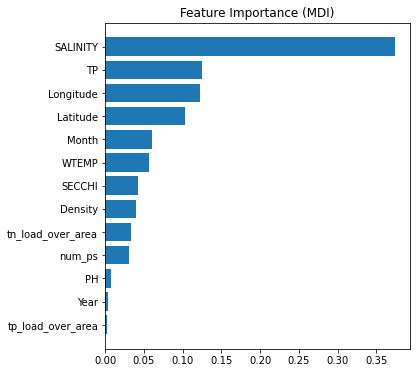

In [393]:
# Feature Importance without standardizing
feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

### Plotting Partial Dependence

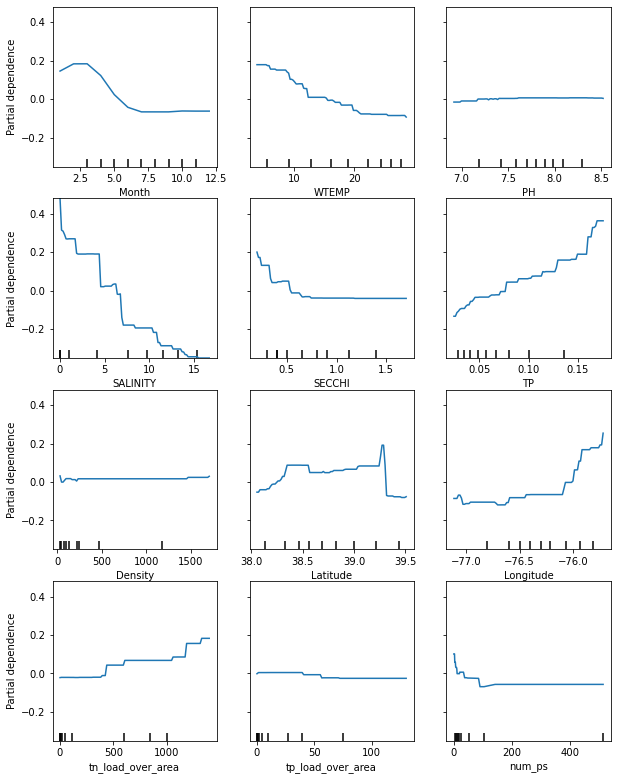

In [394]:
plt.rcParams["figure.figsize"] = (10,13.5)
plot_partial_dependence(xg_reg, X_train, [i for i in range(1,13)])

## SARIMAX Model

In [427]:
# Most frequent point
test_point = water['Point'].value_counts().index[2]
water_point = water.loc[water['Point'] == test_point, :].reset_index(drop = True)

water_point = water_point[['Year', 'Month', 'SALINITY', 'SECCHI', 'WTEMP', 'PH', 'Density', 'tn_load_over_area', 'tp_load_over_area',
                          'TN', 'TP']]
water_point = pd.concat([water_point, pd.get_dummies(water_point['Month'], prefix = 'month')], axis = 1)
water_point = water_point.drop('month_12', axis = 1)

In [566]:
import statsmodels as sm

In [428]:
water_point_ts = water_point.copy()
# This line will drop data after 2013 as it has no point source data
water_point_ts = water_point_ts.dropna()

# Extract month dummies
water_point_ts_month_dummies = water_point_ts.iloc[:, -12:]
# Remove month dummies
water_point_ts = water_point_ts.iloc[:, :-12]

In [429]:
# Add Year and Month
water_point_ts['Date'] = water_point_ts.apply(lambda row: str(int(row['Year'])) + '-' + 
                                        ('0' + str(int(row['Month'])) if len(str(int(row['Month']))) == 1 else str(int(row['Month']))), axis = 1)
# Convert Year and Month into datetime object
water_point_ts['Date'] = pd.to_datetime(water_point_ts['Date'], format = '%Y-%m')

# Generate month date ranges
full_dates_df = pd.date_range(water_point_ts['Date'][0], water_point_ts['Date'][len(water_point_ts) - 1], freq = 'MS')
full_dates_df = pd.DataFrame({'Date': full_dates_df})
# Merge dataset into the full month index
water_point_ts = full_dates_df.merge(water_point_ts, on = 'Date', how = 'left')

# Remove Year and Month columns
water_point_ts = water_point_ts.drop(['Year', 'Month'], axis = 1)

# Interpolate using linear
water_point_ts = water_point_ts.interpolate()

In [430]:
# Merge month dummies
water_point_ts = pd.concat([water_point_ts, water_point_ts_month_dummies], axis = 1)

# Set Index to DateTime
water_point_ts = water_point_ts.set_index(water_point_ts['Date'], drop = True)
water_point_ts = water_point_ts.drop('Date', axis = 1)

water_point_ts['tn_load_over_area'] = water_point_ts['tn_load_over_area'] / 1000
water_point_ts['tp_load_over_area'] = water_point_ts['tp_load_over_area'] / 1000

Seasonal decomposition:
https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.DecomposeResult.html#statsmodels.tsa.seasonal.DecomposeResult

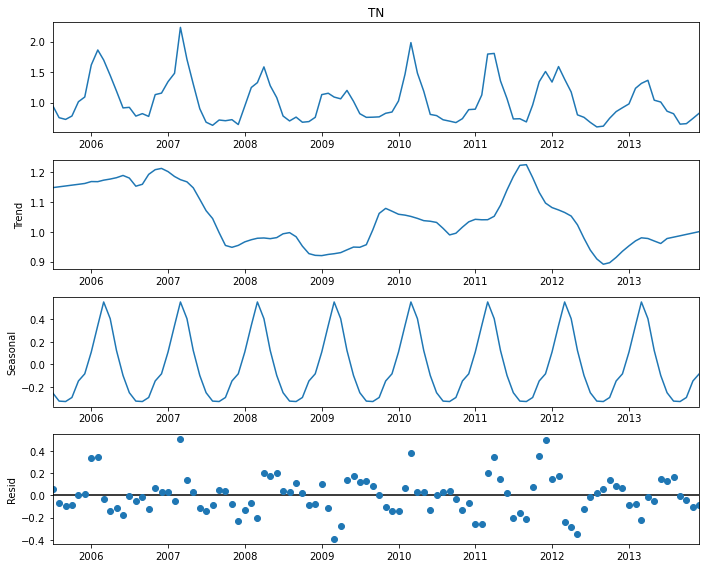

In [567]:
# Seasonal decompose
plt.rcParams["figure.figsize"] = (10,8)
water_point_decomp = seasonal_decompose(water_point_ts['TN'], model = 'additive', extrapolate_trend = 'freq', period = 12)
# Plot (assigning it to nothing is so that we can )
_ = water_point_decomp.plot()

In [415]:
water_point_ts.columns

Index(['Point', 'SALINITY', 'SECCHI', 'WTEMP', 'Density', 'tn_load_over_area',
       'tp_load_over_area', 'TN', 'TP', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11'],
      dtype='object')

In [564]:
# New train/holdout dates, with point source data
train_start, train_end = '2005-07-01', '2011-06-01'
test_start, test_end = '2011-07-01', '2013-12-01'
train = water_point_ts['TN'][train_start:train_end]
test = water_point_ts['TN'][test_start:test_end]
exog_train = water_point_ts[train_start:train_end].drop(['TN'], axis = 1)
exog_test = water_point_ts[test_start:test_end].drop(['TN'], axis = 1)
exog_train = exog_train.fillna(0)
exog_test = exog_test.fillna(0)

In [524]:
# Old train/holdout dates, without point source data
# train_start, train_end = '2005-07-01', '2014-12-01'
# test_start, test_end = '2015-01-01', '2019-11-01'
# train = water_point_ts['TN'][train_start:train_end]
# test = water_point_ts['TN'][test_start:test_end]
# exog_train = water_point_ts[train_start:train_end].drop(['TP', 'TN', 'month_12'], axis = 1)
# exog_test = water_point_ts[test_start:test_end].drop(['TP', 'TN', 'month_12'], axis = 1)
# exog_train = exog_train.fillna(0)
# exog_test = exog_test.fillna(0)

Since the ADF p-value is greater than 0.05, it shows that the time series is not stationary.

1.2424186265360315e-05
5.870245768229316e-09


AttributeError: module 'statsmodels.graphics.api' has no attribute 'tsaplots'

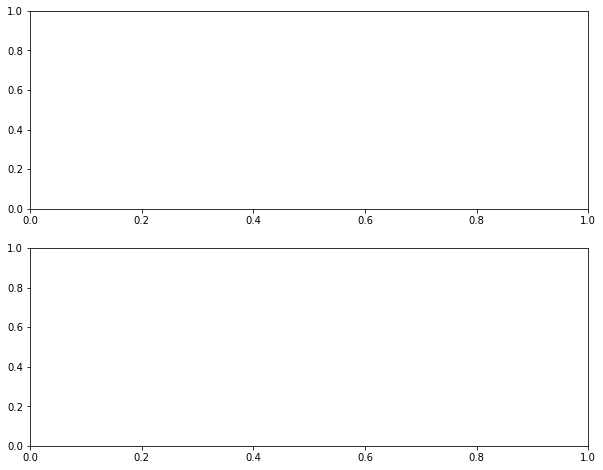

In [565]:
# Model Selection

# ADF test to test stationarity of data
adf = sm.tsa.stattools.adfuller(water_point_ts['TP'], regression = 'ct')
print(adf[1])
# Difference the time series to make it stationary
adf = sm.tsa.stattools.adfuller(water_point_ts['TP'].diff().dropna(), regression = 'ct')
print(adf[1])

# Plot the ACF and PACF

fig,ax = plt.subplots(2,1)
fig = sm.graphics.tsaplots.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsaplots.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()



In [441]:
# Choose the best ARMA order - we'll choose 2,2
sm.tsa.stattools.arma_order_select_ic(train, max_ar = 5, max_ma = 5, ic = 'aic', trend = 'c')

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning:

overflow encountered in exp

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning:

overflow encountered in exp

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\U

{'aic':             0           1           2           3           4           5
 0 -650.566174 -683.876431 -688.438756 -688.336312 -692.077539 -697.674176
 1 -686.073756 -687.060964 -687.059453 -688.014293 -701.167737 -699.196122
 2 -689.286243 -703.454112 -701.480442 -700.226000 -699.249399 -698.339910
 3 -692.488357 -701.485586 -699.743633 -697.460714 -697.734758 -695.878248
 4 -692.308528 -690.780115 -697.460017 -698.718561         NaN -697.454069
 5 -690.311207 -688.795498 -695.869772 -695.897885 -695.026446 -664.453099,
 'aic_min_order': (2, 1)}

In [576]:
# Run the ARIMA model
sarimax = SARIMAX(train, order = (2,0,2), seasonal_order = (0,0,0,0), exog = exog_train).fit()
sarimax.summary()
sarimax_no_tp = SARIMAX(train, order = (2,0,2), seasonal_order = (0,0,0,0), exog = exog_train.drop('TP', axis = 1)).fit()
sarima = SARIMAX(train, order = (2,0,2), seasonal_order = (2,0,2,12)).fit()

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization fai

Jarque-Barra test Prob is under 005 - means that the model residuals are not following normal distribution - hence some information is still remaining in the residuals.

0.08330265829898624
0.09071947561403498
0.048422978730275824


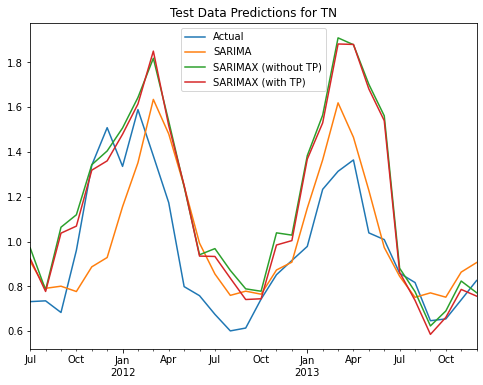

In [577]:
# Make predictions in the holdout period
plt.rcParams["figure.figsize"] = (8,6)
pred = sarimax.predict(train_end, test_end, exog = exog_test)[1:]
pred2 = sarimax_no_tp.predict(train_end, test_end, exog = exog_test.drop('TP', axis = 1))[1:]
pred3 = sarima.predict(train_end, test_end)[1:]
pd.DataFrame({'Actual': test, 'SARIMA': pred3, 'SARIMAX (without TP)': pred2, 'SARIMAX (with TP)': pred}).plot(title = 'Test Data Predictions for TN')

print(mean_squared_error(test,pred))
print(mean_squared_error(test,pred2))
print(mean_squared_error(test,pred3))

## Look at the Land Use Data

In [487]:
land_use = pd.read_csv('land_use.csv')

In [477]:
import statsmodels.api as sm

In [526]:
# Select the relevant columns
water_lu = water[['Year', 'Month', 'Point', 'HUC12', 'Density', 'Latitude', 'Longitude', 'WTEMP', 'PH', 'SALINITY', 'SECCHI', 'TP', 'TN', 'tn_load_over_area', 'tp_load_over_area', 'num_ps']].dropna()
# One hot encoding the months
water_lu = pd.concat([water_lu, pd.get_dummies(water_lu['Month'], prefix = 'month')], axis = 1)
# Merge in the land use data
water_lu = water_lu.merge(land_use, on = 'HUC12', how = 'right')
water_lu = water_lu.drop(['Name', 'Shape_Leng', 'Shape_Area', 'Month', 'Year', 'month_12', 'HUC12', 'num_ps', 'Point'], axis = 1).dropna()

In [528]:
water_lu = sm.add_constant(water_lu)
model = sm.OLS(water_lu['TN'], water_lu[['Density', 'WTEMP', 'PH', 'SALINITY', 'SECCHI',
       'TP', 'tn_load_over_area', 'tp_load_over_area', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'Impervious Road (%)',
       'Impervious Non-road (%)',
       'Cropland/Pasture (%)', 'Forest (%)']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     TN   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              692.7
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                   3.38e-298
Time:                        00:50:26   Log-Likelihood:                          207.06
No. Observations:                 410   AIC:                                     -368.1
Df Residuals:                     387   BIC:                                     -275.8
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Density                    -0.0004      0.000     -2.659      0.008      -0.001      -0.000
WTEMP                      -0.0003      0.004     -0.078      0.938      -0.009       0.008
PH                          0.1115      0.009     12.373      0.000       0.094       0.129
SALINITY                   -0.0233      0.004     -5.715      0.000      -0.031      -0.015
SECCHI                     -0.0149      0.025     -0.609      0.543      -0.063       0.033
TP                          5.8726      0.306     19.181      0.000       5.271       6.475
tn_load_over_area          -0.0010      0.002     -0.413      0.680      -0.006       0.004
tp_load_over_area           0.0276      0.014      2.026      0.043       0.001       0.054
month_1                     0.0742      0.056      1.330      0.184      -0.036       0.184
month_2                     0.1273      0.054      2.356      0.019       0.021       0.233
month_3                     0.2396      0.051      4.668      0.000       0.139       0.341
month_4                     0.1385      0.049      2.818      0.005       0.042       0.235
month_5                     0.0509      0.064      0.792      0.429      -0.075       0.177
month_6                    -0.0235      0.085     -0.275      0.783      -0.191       0.144
month_7                    -0.1014      0.096     -1.059      0.290      -0.290       0.087
month_8                    -0.1402      0.096     -1.461      0.145      -0.329       0.048
month_9                    -0.1265      0.084     -1.504      0.133      -0.292       0.039
month_10                   -0.0269      0.064     -0.423      0.673      -0.152       0.098
month_11                   -0.0459      0.054     -0.858      0.391      -0.151       0.059
Impervious Road (%)         0.7522      0.251      2.994      0.003       0.258       1.246
Impervious Non-road (%)    -0.2999      0.118     -2.535      0.012      -0.532      -0.067
Cropland/Pasture (%)       -0.0081      0.003     -2.433      0.015      -0.015      -0.002
Forest (%)                 -0.0044      0.001     -6.867      0.000      -0.006      -0.003
==============================================================================
Omnibus:                       18.786   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.575
Skew:                           0.163   Prob(JB):                     3.45e-10
Kurtosis:                       4.564   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The conditi

In [529]:
water_lu = sm.add_constant(water_lu)
model = sm.OLS(water_lu['TP'], water_lu[['Density', 'WTEMP', 'PH', 'SALINITY', 'SECCHI',
       'TN', 'tn_load_over_area', 'tp_load_over_area', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'Impervious Road (%)',
       'Impervious Non-road (%)',
       'Cropland/Pasture (%)', 'Forest (%)']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     TP   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              193.9
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                   1.83e-196
Time:                        00:50:35   Log-Likelihood:                          1080.2
No. Observations:                 410   AIC:                                     -2114.
Df Residuals:                     387   BIC:                                     -2022.
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Density                  2.201e-06   2.03e-05      0.109      0.914   -3.77e-05    4.21e-05
WTEMP                       0.0011      0.001      2.063      0.040    4.96e-05       0.002
PH                         -0.0089      0.001     -7.525      0.000      -0.011      -0.007
SALINITY                    0.0027      0.000      5.608      0.000       0.002       0.004
SECCHI                     -0.0110      0.003     -3.825      0.000      -0.017      -0.005
TN                          0.0830      0.004     19.181      0.000       0.074       0.091
tn_load_over_area          -0.0002      0.000     -0.619      0.536      -0.001       0.000
tp_load_over_area          -0.0024      0.002     -1.498      0.135      -0.006       0.001
month_1                    -0.0030      0.007     -0.456      0.649      -0.016       0.010
month_2                    -0.0070      0.006     -1.091      0.276      -0.020       0.006
month_3                    -0.0200      0.006     -3.225      0.001      -0.032      -0.008
month_4                    -0.0110      0.006     -1.867      0.063      -0.023       0.001
month_5                    -0.0081      0.008     -1.067      0.287      -0.023       0.007
month_6                    -0.0115      0.010     -1.140      0.255      -0.031       0.008
month_7                    -0.0022      0.011     -0.191      0.849      -0.025       0.020
month_8                     0.0059      0.011      0.515      0.607      -0.017       0.028
month_9                     0.0052      0.010      0.519      0.604      -0.015       0.025
month_10                   -0.0026      0.008     -0.343      0.732      -0.017       0.012
month_11                    0.0023      0.006      0.354      0.724      -0.010       0.015
Impervious Road (%)        -0.0548      0.030     -1.823      0.069      -0.114       0.004
Impervious Non-road (%)     0.0268      0.014      1.896      0.059      -0.001       0.055
Cropland/Pasture (%)        0.0011      0.000      2.692      0.007       0.000       0.002
Forest (%)                  0.0003   8.02e-05      3.280      0.001       0.000       0.000
==============================================================================
Omnibus:                      215.830   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2341.100
Skew:                           1.991   Prob(JB):                         0.00
Kurtosis:                      14.008   Cond. No.                     1.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The conditi